# Set carbon emission targets

In this notebook a target for the emission is set and the required tax rate is calculated. This involves inverting the model, and takes some time.  

In [1]:
# Import modelflow

%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

from ipywidgets import interact,Dropdown,Checkbox
from IPython.display import display, clear_output,Latex, Markdown
import pandas as pd

import modelmf
import modeljupyter as mj
from modelvis import waterplot

from modelinvert import targets_instruments
from modelclass import model
model.widescreen()

model.scroll_off()

In [3]:
# Load model and data, and run 

masia,baseline = model.modelload('Asia_sep7.pcim',run=1,silent=1)
from inject import inject
inject(masia)  
masia.lastdf = masia.basedf.copy()

# Parameters in this experiment


In [4]:
countries_of_interest = [country for country in masia.countries_ASEAN]
                         
instruments = [[f'{country}_GCARBR_A'] for country in countries_of_interest]
target_var  = [f'{country}_CO2' for country in countries_of_interest]
delay = 1
target_growth = 1.01

# The instrument variables

In [5]:
print(instruments)

[['KHM_GCARBR_A'], ['IDN_GCARBR_A'], ['LAO_GCARBR_A'], ['MYS_GCARBR_A'], ['MMR_GCARBR_A'], ['PHL_GCARBR_A'], ['THA_GCARBR_A'], ['VNM_GCARBR_A']]


# The target variables

In [6]:
print(target_var)

['KHM_CO2', 'IDN_CO2', 'LAO_CO2', 'MYS_CO2', 'MMR_CO2', 'PHL_CO2', 'THA_CO2', 'VNM_CO2']


# Emission in Business as usual scenario

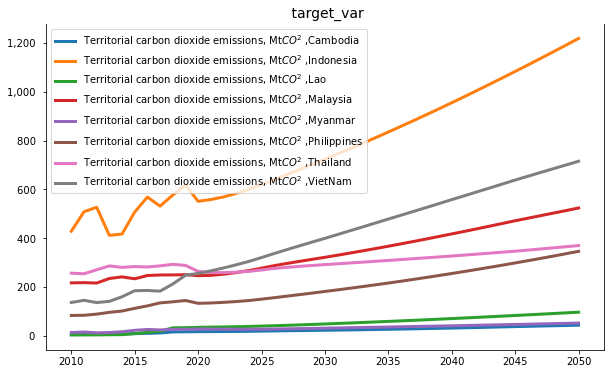

In [7]:
model.plot_basis('target_var',df = masia.basedf.loc[2010:,target_var].rename(columns=masia.var_description),legend=1);

# Carbon tax in Business as usual scenario

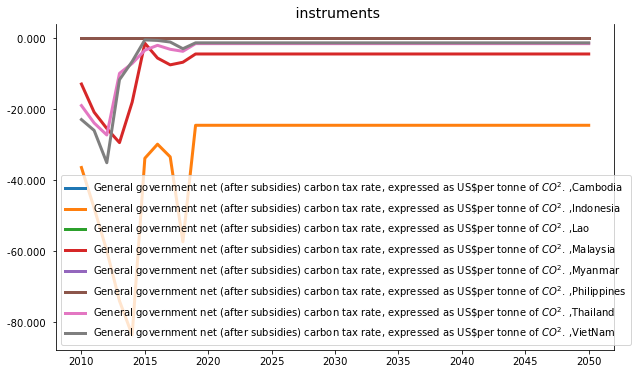

In [8]:
model.plot_basis('instruments',df = masia.basedf.loc[2010:,[i[0][:-2] for i in instruments]].rename(columns=masia.var_description),legend=1);

# Lets look at the impact of increasing the tax with 10 in 2022

In [9]:
experiment = baseline.copy()
experiment.loc[2022,instrumentlist]= experiment.loc[2022,(instrumentlist := [i[0] for i in instruments])] + 10 
result = masia(experiment,progressbar = 0,silent=1)

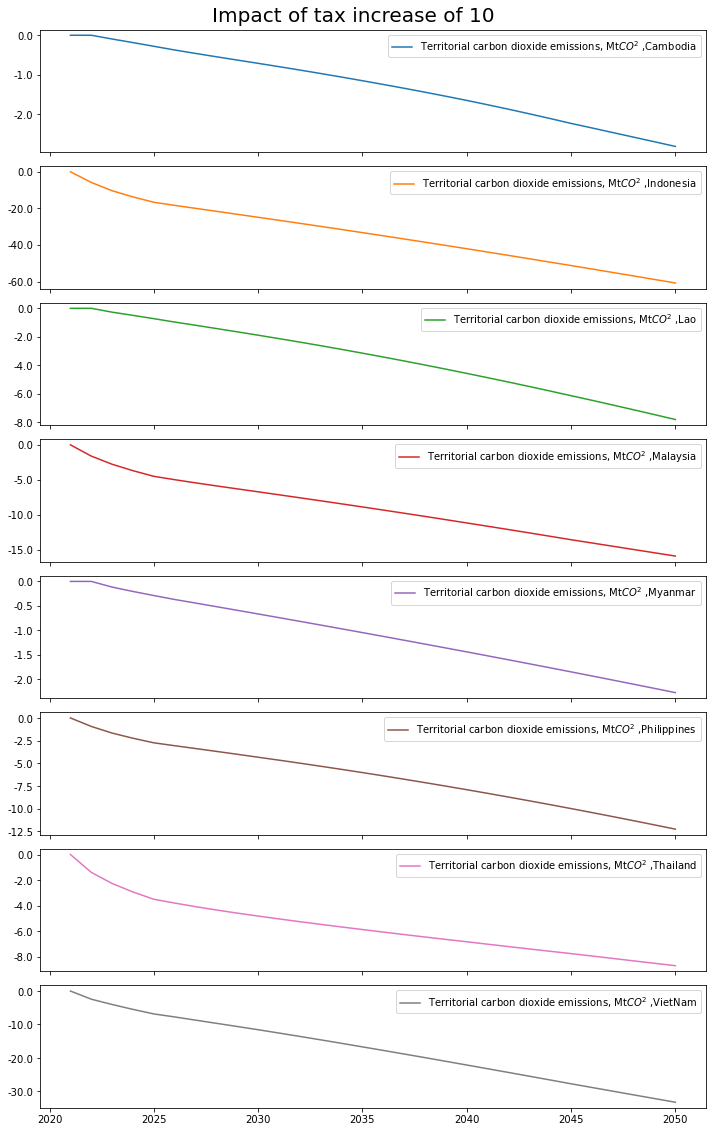

In [10]:
masia[target_var].dif.rename().plot(colrow  = 1,title = 'Impact of tax increase of 10 ',top=0.96,sharey=0);
masia[target_var].dif.df;
    

# Define a dataframe with with target growth rates in $CO^2$

In [11]:
target_before = baseline[target_var].loc[2022+delay-1:,:]
calclines = '\n'.join(f'{t} = {t}(-1) * (1+{target_growth}/100)' for t in target_var)
target = target_before.mfcalc(calclines).loc[2022:,:]

# Show the target developement in emision 

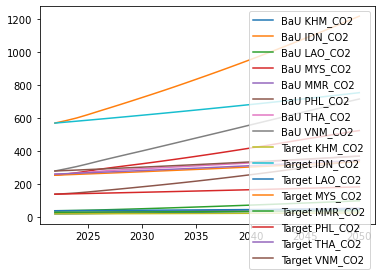

In [12]:
if 1:
    t = pd.concat([target_before.rename(columns={c: 'BaU '+c for c in target_before.columns}),
                   target.rename(columns={c: 'Target '+c for c in target_before.columns})],axis=1)
    t.plot()

# Setup the Target/instrument device

In [13]:
t_i_baseline = baseline.copy()
t_i = targets_instruments(databank=t_i_baseline,targets=target,instruments=instruments,
                          model=masia,DefaultImpuls=10,defaultconv=0.5,varimpulse=True,nonlin=4,silent=0)

# Run the device. 
And fetch a cup of coffee. 
Serious calculations are to be performed

In [14]:
t_i.debug=0
res = t_i(delay=delay,shortfall=0)

Update jacobi: 2022 effects from 2021
Period: 2022
Period: 2022  Target instrument iteration: 0  Max distance: 0.000
Period: 2023
Period: 2023  Target instrument iteration: 0  Max distance: 10.151
Period: 2023  Target instrument iteration: 1  Max distance: 2.067
Period: 2023  Target instrument iteration: 2  Max distance: 0.277
Period: 2024
Period: 2024  Target instrument iteration: 0  Max distance: 7.924
Period: 2024  Target instrument iteration: 1  Max distance: 1.776
Period: 2024  Target instrument iteration: 2  Max distance: 0.588
Period: 2024  Target instrument iteration: 3  Max distance: 0.234
Period: 2025
Period: 2025  Target instrument iteration: 0  Max distance: 8.651
Period: 2025  Target instrument iteration: 1  Max distance: 3.117
Period: 2025  Target instrument iteration: 2  Max distance: 1.572
Period: 2025  Target instrument iteration: 3  Max distance: 0.826
Period: 2025  Target instrument iteration: 4  Max distance: 0.443
Period: 2026
Period: 2026  Target instrument iterat

Period: 2037  Target instrument iteration: 3  Max distance: 1.595
Period: 2037  Target instrument iteration: 4  Max distance: 1.302
Update jacobi: 2037 effects from 2036
Period: 2037  Target instrument iteration: 5  Max distance: 1.064
Period: 2037  Target instrument iteration: 6  Max distance: 0.871
Period: 2037  Target instrument iteration: 7  Max distance: 0.713
Period: 2037  Target instrument iteration: 8  Max distance: 0.585
Update jacobi: 2037 effects from 2036
Period: 2037  Target instrument iteration: 9  Max distance: 0.479
Period: 2038
Period: 2038  Target instrument iteration: 0  Max distance: 2.773
Period: 2038  Target instrument iteration: 1  Max distance: 2.284
Period: 2038  Target instrument iteration: 2  Max distance: 1.884
Period: 2038  Target instrument iteration: 3  Max distance: 1.557
Period: 2038  Target instrument iteration: 4  Max distance: 1.288
Update jacobi: 2038 effects from 2037
Period: 2038  Target instrument iteration: 5  Max distance: 1.067
Period: 2038  T

Period: 2049  Target instrument iteration: 0  Max distance: 0.984
Period: 2049  Target instrument iteration: 1  Max distance: 0.867
Period: 2049  Target instrument iteration: 2  Max distance: 0.764
Period: 2049  Target instrument iteration: 3  Max distance: 0.674
Period: 2049  Target instrument iteration: 4  Max distance: 0.594
Update jacobi: 2049 effects from 2048
Period: 2049  Target instrument iteration: 5  Max distance: 0.524
Period: 2049  Target instrument iteration: 6  Max distance: 0.462
Period: 2050
Period: 2050  Target instrument iteration: 0  Max distance: 0.955
Period: 2050  Target instrument iteration: 1  Max distance: 0.843
Period: 2050  Target instrument iteration: 2  Max distance: 0.745
Period: 2050  Target instrument iteration: 3  Max distance: 0.658
Period: 2050  Target instrument iteration: 4  Max distance: 0.581
Update jacobi: 2050 effects from 2049
Period: 2050  Target instrument iteration: 5  Max distance: 0.514
Period: 2050  Target instrument iteration: 6  Max dis

# The target is nearly meet. 
The delay causes a slight difference to the target

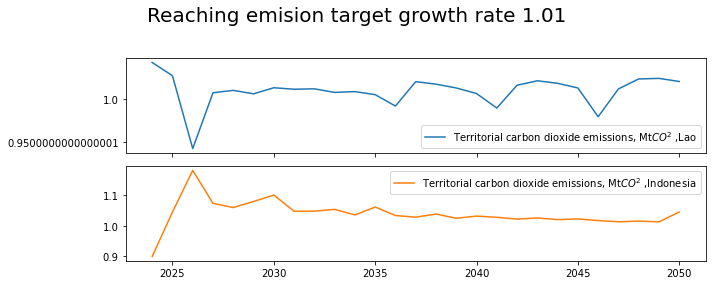

In [15]:
with masia.set_smpl(2024,2050):

    masia['LAO_co2 idn_co2'].pct.mul100.rename().plot(
        title=f'Reaching emision target growth rate {target_growth:,.2f}',colrow=1,top=0.8,sharey=0);

# Emission and tax after inverting the model 

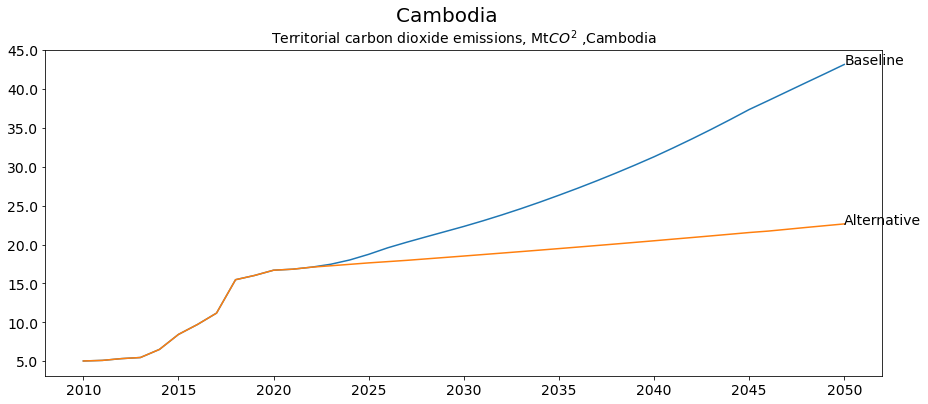

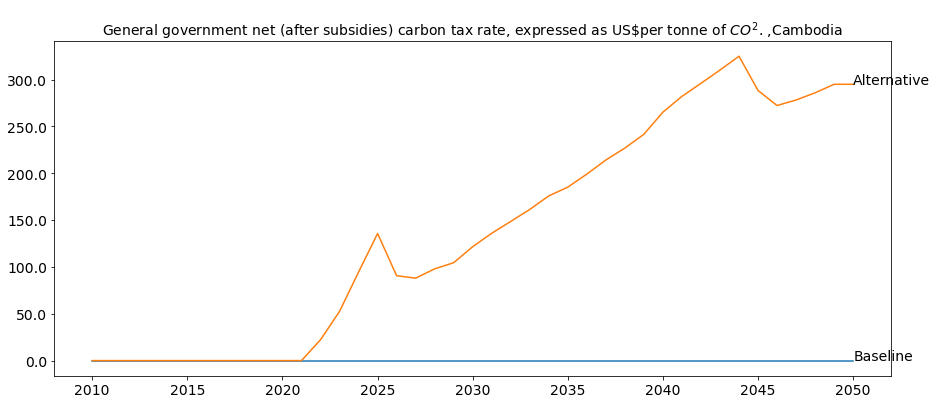

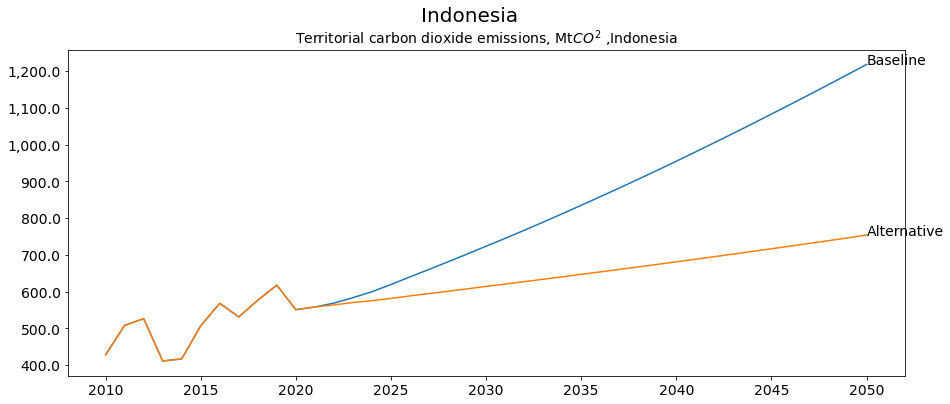

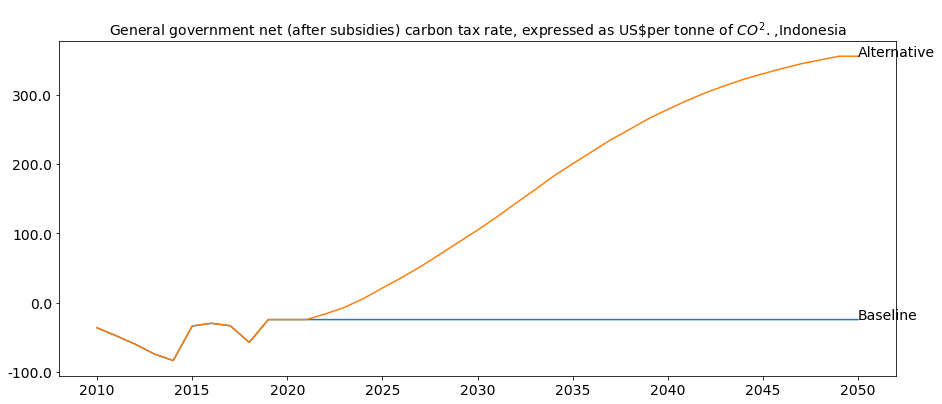

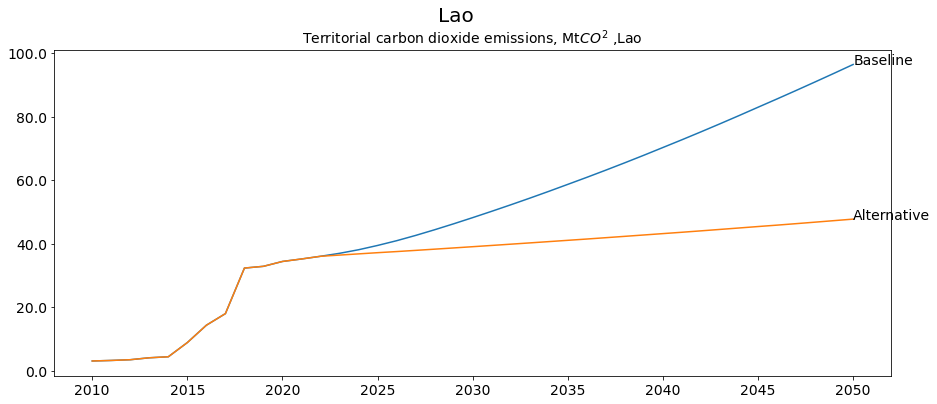

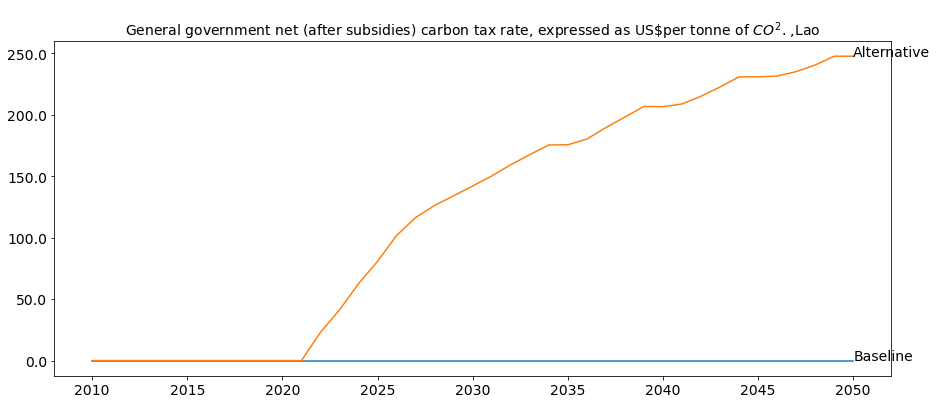

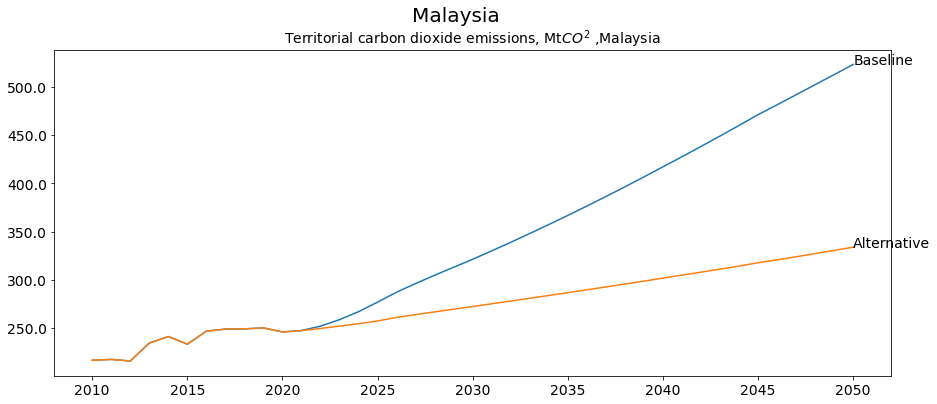

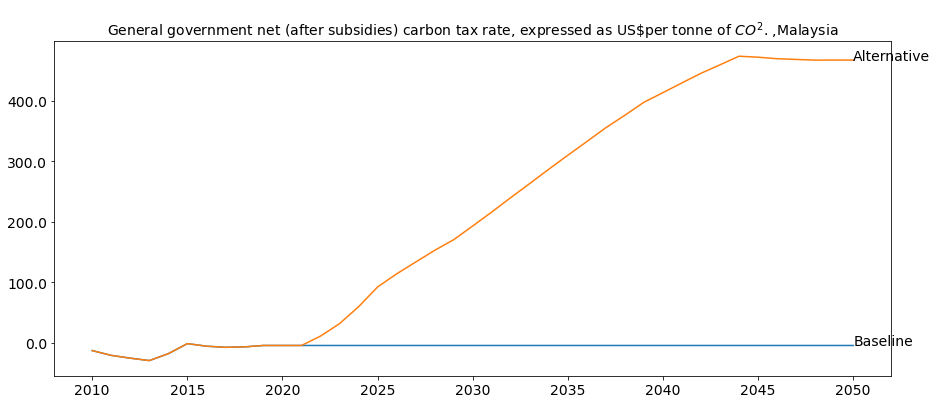

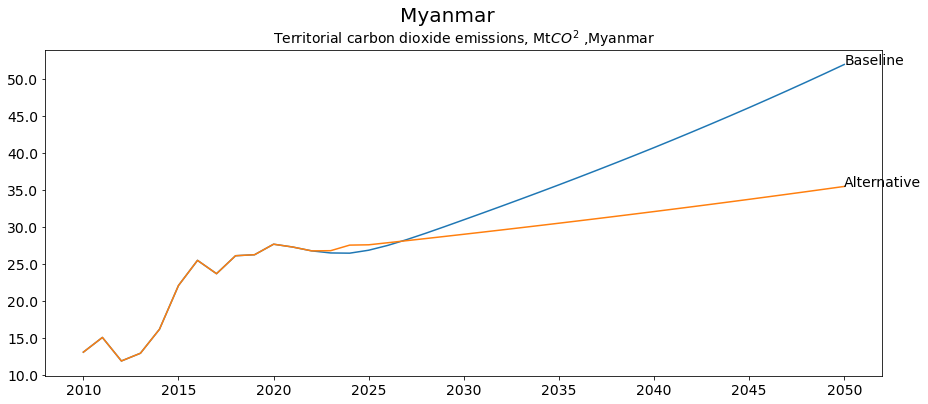

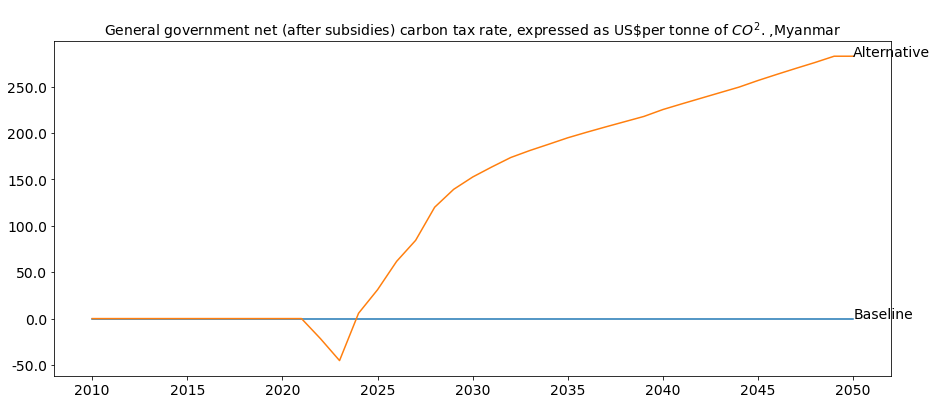

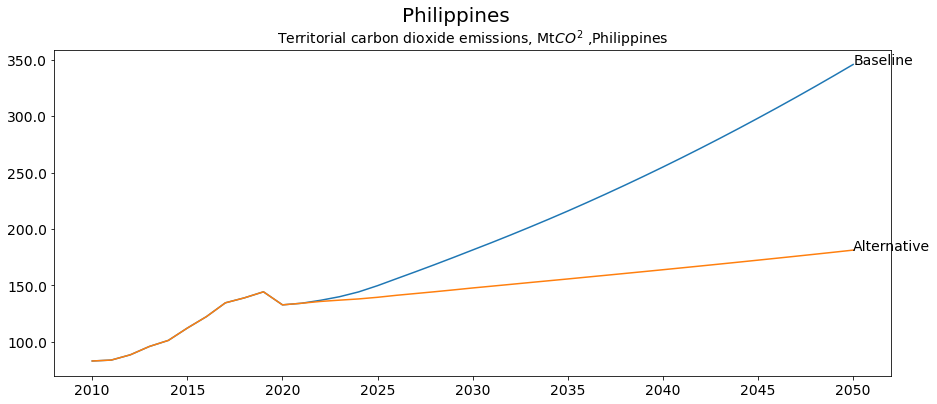

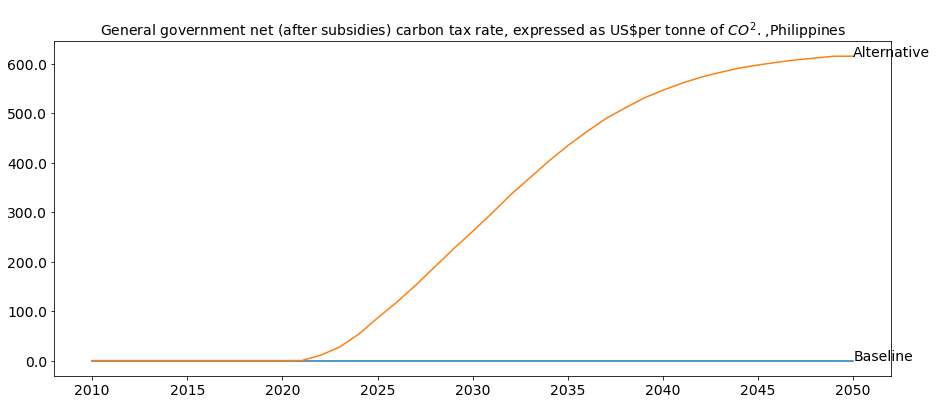

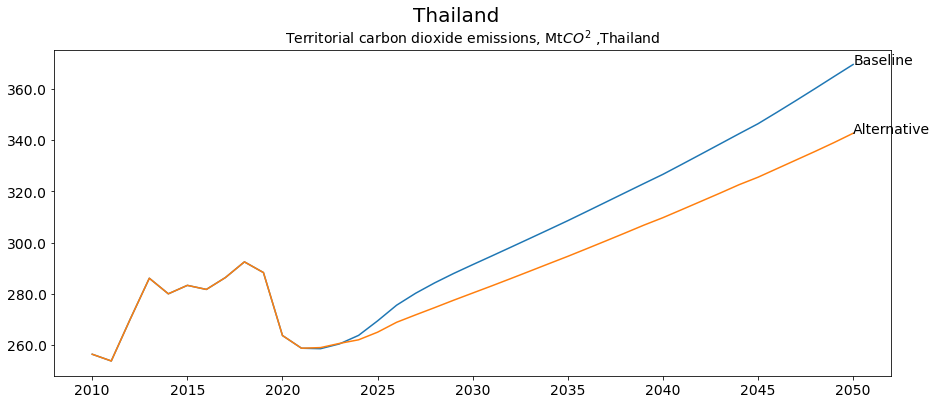

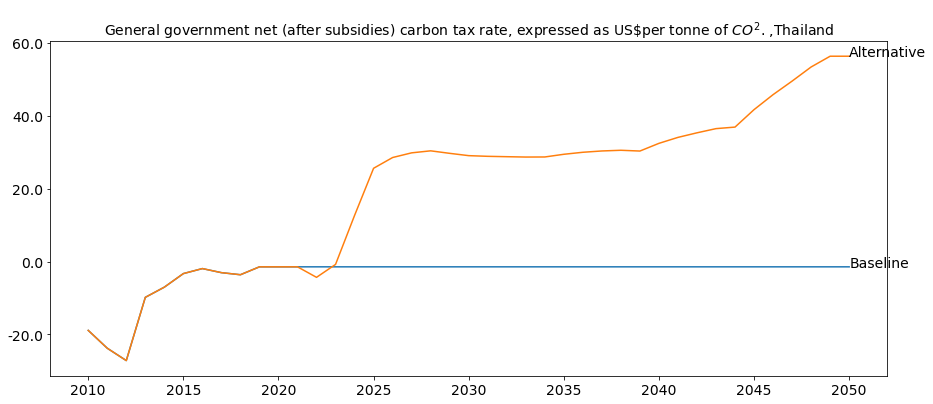

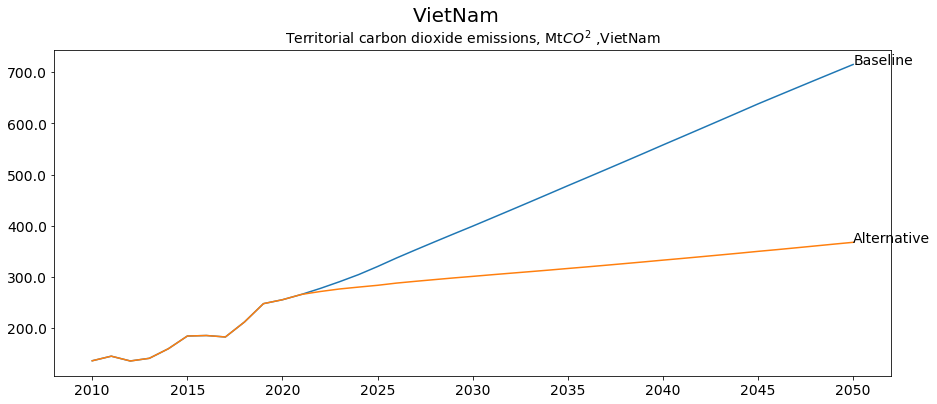

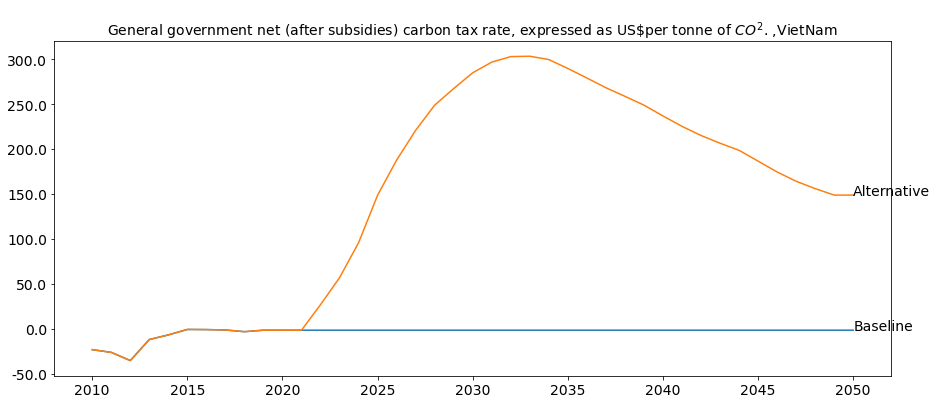

In [16]:
with masia.set_smpl(2010,2050):
    for country in countries_of_interest:
        masia[f'{country}_co2' ].plot_alt(title=f'{masia.iso_dict[country]} ',top=0.88);        
        masia[f'{country}_GCARBR' ].plot_alt(title=f' ',top=0.90);